# `CLOUD.jl` - 1D linear advection

In [1]:
using CLOUD
using OrdinaryDiffEq
using TimerOutputs
plots_path = "../plots/advection_dgsem_1D/"
results_path = "../results/advection_dgsem_1D/";

Define the physical problem (advection of a sine wave)

In [2]:
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 4*π/L  # wave number
T = 1*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a strong-form DGSEM-LGL scheme of degree `p` with `M` elements and periodic boundary conditions

In [3]:
M = 5  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Line(), volume_quadrature_rule=LGLQuadrature())
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true);

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [4]:
reset_timer!()
n_s = 10
dt_scale = 0.01
dt = dt_scale*(L/M)/(a*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            11.8s / 21.2%           2.08GiB / 23.9%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   21.0k    2.50s   100%   119μs    508MiB  100%   24.8KiB
   eval residual         105k    1.01s  40.5%  9.64μs    198MiB  38.9%  1.93KiB
     facet terms         105k    289ms  11.6%  2.75μs   77.9MiB  15.3%     778B
     volume terms        105k    155ms  6.19%  1.47μs   73.3MiB  14.4%     731B
     mass matrix solve   105k   18.1ms  0.72%   172ns   11.2MiB  2.21%     112B
   eval numerical flux   105k    333ms  13.3%  3.17μs    135MiB  26.6%  1.32KiB
   extrapolate solu...   105k    187ms 

Visualize the solution

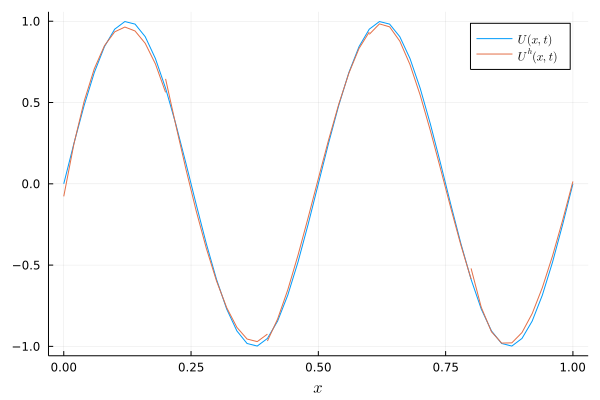

In [5]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [6]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.03339257961924638]


Conservation (initial/final/diff):
[8.326672684688674e-17][5.828670879282072e-16][4.996003610813204e-16]


Energy (initial/final/diff):
[0.5000000000000001][0.4789624785188836][-0.021037521481116483]
